# RETO KAGGLE - FUNDAMENTOS

## LIBRERIAS

In [47]:
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

## VISUALIZACIÓN

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## EXTRACT

In [3]:
table = pq.read_table(r"D:\MAESTRIA CIENCIA DE DATOS\Fundamentos2\KAGGLE\df_train.parquet")
df_train = table.to_pandas()

table = pq.read_table(r"D:\MAESTRIA CIENCIA DE DATOS\Fundamentos2\KAGGLE\df_test.parquet")
df_test = table.to_pandas()

## EDA

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23494 entries, 16484 to 9409
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MEDICAMENTOS                   23494 non-null  float64
 1   MEDICINA ESPECIALIZADA         23494 non-null  float64
 2   MEDICINA GENERAL               23494 non-null  float64
 3   Cant_gr_flia                   23494 non-null  int64  
 4   Cant_riesgos_flia_mean         23494 non-null  float64
 5   min_Tiempo_CP_Fliar            8 non-null      float64
 6   Cant_Fliar_CP                  23494 non-null  float64
 7   psa_max_gr_flia                164 non-null    float64
 8   psa_min_gr_flia                164 non-null    float64
 9   Cant_Fliar_riesgos             23494 non-null  float64
 10  cantidad_serv_flia             23494 non-null  float64
 11  Pendiente_flia                 23494 non-null  float64
 12  Intercepto_flia                23494 non-null  f

#### CONVERTIR EN CATEGORÍAS LAS VARIABLES QUE APARECEN COMO ENTEROS PERO SÓLO TIENEN 1 Y 0

In [114]:
df_train['Cant_Fliar_CP'] = df_train['Cant_Fliar_CP'].astype('category')

#### REVISAR LOS NO NULOS DE LAS COLUMNAS QUE MÁS NULOS TIENE

In [26]:
def get_nulos(df):
    nulos_mayores_que_cero = df.isnull().sum()
    nulos_mayores_que_cero = nulos_mayores_que_cero[nulos_mayores_que_cero > 0]
    print(nulos_mayores_que_cero)

In [27]:
get_nulos(df_train)

min_Tiempo_CP_Fliar      23486
psa_max_gr_flia          23330
psa_min_gr_flia          23330
IMC                      10364
AGRUPACION_SISTOLICA      3320
AGRUPACION_DIASTOLICA     3320
RIESGOS                  16283
PERDIDA_DE_PESO          17723
CANCER_MAMA_FAMILIAR      6802
dtype: int64


In [30]:
df_train.columns[df_train.isin(['None']).any()]

Index(['ESTADO_CIVI', 'estrato', 'parentesco'], dtype='object')

In [31]:
df_train = df_train.replace({'None': np.nan})

In [32]:
get_nulos(df_train)

min_Tiempo_CP_Fliar      23486
psa_max_gr_flia          23330
psa_min_gr_flia          23330
ESTADO_CIVI                125
estrato                      2
IMC                      10364
AGRUPACION_SISTOLICA      3320
AGRUPACION_DIASTOLICA     3320
parentesco               17125
RIESGOS                  16283
PERDIDA_DE_PESO          17723
CANCER_MAMA_FAMILIAR      6802
dtype: int64


In [33]:
df_train['parentesco'].unique()

array([nan, 'Conyuge', 'Trabajador', 'Otros', 'Sin Descripcion', 'Padres',
       'Hijo'], dtype=object)

##### Dado que existe una categoría 'Sin Descripcion', para la variable parentesco, todos los nulos se pueden categorizar en esa.

In [34]:
df_train['ESTADO_CIVI'].unique()

array(['UL', 'SO', 'CA', 'SE', nan, 'VI'], dtype=object)

In [35]:
df_train['estrato'].unique()

array(['1', '2', '3', '0', nan], dtype=object)

In [5]:
df_train[df_train['min_Tiempo_CP_Fliar'].notna()]

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,cantidad_serv_flia,Pendiente_flia,Intercepto_flia,Promedio_costo_flia,ESTADO_CIVI,PROGRAMA,estrato,IMC,AGRUPACION_SISTOLICA,AGRUPACION_DIASTOLICA,parentesco,EDAD,RIESGOS,CANTIDAD_SERVICIOS,PERDIDA_DE_PESO,TIEMPO_ULTIMA_CITA,conteo_dx_diferentes,TIEMPO_AFILIACION,CANCER_MAMA_FAMILIAR,CANCER_OTRO_SITIO,CANCER_OTRO_SITIO_FAMILIAR,HIPERTENSION,HIPERTENSION_FAMILIAR,DIABETES,DIABETES_FAMILIAR,CORONARIOS,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2040,0.0,0.0,0.0,7,0.000000,80.0,1.0,0.111,0.074,0.0,58.0,-6.030677e+04,7.248799e+05,5.138062e+05,CA,POS,1,None,Normal,Hipotenso,Trabajador,53.0,NaN,6.0,NaN,1.0,1.0,298.0,0,1,1,1,0,1,0,1,1,1,0,1,0,0,0,0.000000e+00,1.051100e+05,1.051100e+05
31015,48.0,17.0,6.0,3,0.333333,284.0,1.0,0.006,0.005,1.0,238.0,1.618443e+06,-2.282413e+06,3.382137e+06,SO,POS,1,Normal,Normal,Normal,None,49.0,1.0,89.0,0.00,1.0,17.0,272.0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1.800763e+06,-2.190468e+06,4.112203e+06
22231,2.0,4.0,1.0,3,0.000000,23.0,1.0,38.380,0.000,0.0,57.0,-1.985966e+04,1.972175e+05,1.532504e+05,SO,POS,1,Normal,Normal,Normal,None,56.0,NaN,23.0,-1.56,2.0,5.0,43.0,None,2,2,2,2,2,2,2,2,2,2,2,2,2,0,3.555583e+04,2.870493e+04,1.837804e+05
17706,27.0,5.0,6.0,2,0.500000,46.0,1.0,10.700,0.005,1.0,73.0,9.235020e+04,4.361905e+05,7.594162e+05,UL,POS,1,Normal,Normal,Normal,Conyuge,57.0,2.0,33.0,-1.49,1.0,9.0,10.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.218247e+05,-8.323780e+04,3.431485e+05
13338,0.0,2.0,3.0,4,0.250000,87.0,1.0,0.816,0.200,1.0,233.0,-6.884789e+06,3.419994e+07,1.010317e+07,CA,POS,1,None,Normal,Normal,None,51.0,1.0,18.0,NaN,1.0,3.0,189.0,None,2,2,2,2,2,2,2,2,2,2,2,2,2,0,1.233403e+04,2.014104e+05,2.445795e+05
1671,0.0,2.0,0.0,3,0.000000,26.0,1.0,12.600,5.950,0.0,183.0,3.383754e+05,4.130929e+05,1.597407e+06,SO,POS,1,Sobrepeso,Normal,Normal,Trabajador,51.0,NaN,5.0,NaN,1.0,2.0,287.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.244243e+04,-9.903233e+04,2.970970e+05
8816,0.0,0.0,0.0,3,0.000000,66.0,1.0,12.100,2.650,0.0,60.0,-2.146800e+04,5.655113e+05,4.903733e+05,SO,POS,1,None,Normal,Normal,None,51.0,NaN,1.0,NaN,6.0,1.0,38.0,None,2,2,2,2,2,2,2,2,2,2,2,2,2,0,-2.367143e+03,1.104667e+04,1.657000e+04
7196,0.0,0.0,0.0,3,0.000000,148.0,1.0,30.100,5.200,0.0,120.0,4.031457e+06,-8.433197e+06,5.676901e+06,SO,POS,1,Normal,hipertenso,Normal,None,58.0,NaN,2.0,NaN,1.0,1.0,334.0,None,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2.659957e+04,-6.206567e+04,1.861970e+05


In [6]:
df_train['Cant_Fliar_CP'].unique()

array([0., 1.])

In [7]:
df_train[df_train['Cant_Fliar_CP']==1]

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,cantidad_serv_flia,Pendiente_flia,Intercepto_flia,Promedio_costo_flia,ESTADO_CIVI,PROGRAMA,estrato,IMC,AGRUPACION_SISTOLICA,AGRUPACION_DIASTOLICA,parentesco,EDAD,RIESGOS,CANTIDAD_SERVICIOS,PERDIDA_DE_PESO,TIEMPO_ULTIMA_CITA,conteo_dx_diferentes,TIEMPO_AFILIACION,CANCER_MAMA_FAMILIAR,CANCER_OTRO_SITIO,CANCER_OTRO_SITIO_FAMILIAR,HIPERTENSION,HIPERTENSION_FAMILIAR,DIABETES,DIABETES_FAMILIAR,CORONARIOS,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2040,0.0,0.0,0.0,7,0.000000,80.0,1.0,0.111,0.074,0.0,58.0,-6.030677e+04,7.248799e+05,5.138062e+05,CA,POS,1,None,Normal,Hipotenso,Trabajador,53.0,NaN,6.0,NaN,1.0,1.0,298.0,0,1,1,1,0,1,0,1,1,1,0,1,0,0,0,0.000000e+00,1.051100e+05,1.051100e+05
31015,48.0,17.0,6.0,3,0.333333,284.0,1.0,0.006,0.005,1.0,238.0,1.618443e+06,-2.282413e+06,3.382137e+06,SO,POS,1,Normal,Normal,Normal,None,49.0,1.0,89.0,0.00,1.0,17.0,272.0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1.800763e+06,-2.190468e+06,4.112203e+06
22231,2.0,4.0,1.0,3,0.000000,23.0,1.0,38.380,0.000,0.0,57.0,-1.985966e+04,1.972175e+05,1.532504e+05,SO,POS,1,Normal,Normal,Normal,None,56.0,NaN,23.0,-1.56,2.0,5.0,43.0,None,2,2,2,2,2,2,2,2,2,2,2,2,2,0,3.555583e+04,2.870493e+04,1.837804e+05
17706,27.0,5.0,6.0,2,0.500000,46.0,1.0,10.700,0.005,1.0,73.0,9.235020e+04,4.361905e+05,7.594162e+05,UL,POS,1,Normal,Normal,Normal,Conyuge,57.0,2.0,33.0,-1.49,1.0,9.0,10.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.218247e+05,-8.323780e+04,3.431485e+05
13338,0.0,2.0,3.0,4,0.250000,87.0,1.0,0.816,0.200,1.0,233.0,-6.884789e+06,3.419994e+07,1.010317e+07,CA,POS,1,None,Normal,Normal,None,51.0,1.0,18.0,NaN,1.0,3.0,189.0,None,2,2,2,2,2,2,2,2,2,2,2,2,2,0,1.233403e+04,2.014104e+05,2.445795e+05
1671,0.0,2.0,0.0,3,0.000000,26.0,1.0,12.600,5.950,0.0,183.0,3.383754e+05,4.130929e+05,1.597407e+06,SO,POS,1,Sobrepeso,Normal,Normal,Trabajador,51.0,NaN,5.0,NaN,1.0,2.0,287.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.244243e+04,-9.903233e+04,2.970970e+05
8816,0.0,0.0,0.0,3,0.000000,66.0,1.0,12.100,2.650,0.0,60.0,-2.146800e+04,5.655113e+05,4.903733e+05,SO,POS,1,None,Normal,Normal,None,51.0,NaN,1.0,NaN,6.0,1.0,38.0,None,2,2,2,2,2,2,2,2,2,2,2,2,2,0,-2.367143e+03,1.104667e+04,1.657000e+04
7196,0.0,0.0,0.0,3,0.000000,148.0,1.0,30.100,5.200,0.0,120.0,4.031457e+06,-8.433197e+06,5.676901e+06,SO,POS,1,Normal,hipertenso,Normal,None,58.0,NaN,2.0,NaN,1.0,1.0,334.0,None,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2.659957e+04,-6.206567e+04,1.861970e+05


In [8]:
df_test[df_test['Cant_Fliar_CP']==1]

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,cantidad_serv_flia,Pendiente_flia,Intercepto_flia,Promedio_costo_flia,ESTADO_CIVI,PROGRAMA,estrato,IMC,AGRUPACION_SISTOLICA,AGRUPACION_DIASTOLICA,parentesco,EDAD,RIESGOS,CANTIDAD_SERVICIOS,PERDIDA_DE_PESO,TIEMPO_ULTIMA_CITA,conteo_dx_diferentes,TIEMPO_AFILIACION,CANCER_MAMA_FAMILIAR,CANCER_OTRO_SITIO,CANCER_OTRO_SITIO_FAMILIAR,HIPERTENSION,HIPERTENSION_FAMILIAR,DIABETES,DIABETES_FAMILIAR,CORONARIOS,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9701,16.0,3.0,3.0,3,1.000000,61.0,1.0,0.136,0.000,1.0,197.0,2.378620e+05,594260.4,1426777.5,SO,POS,3,Obesidad,Normal,Normal,None,50.0,NaN,28.0,NaN,1.0,5.0,35.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,81679.628571,-27755.866667,258122.833333
3333,3.0,3.0,2.0,6,0.333333,43.0,1.0,34.300,0.222,1.0,220.0,-2.162527e+06,14063187.8,6494342.0,CA,POS,3,Sobrepeso,Normal,Normal,Trabajador,52.0,2.0,6.0,NaN,1.0,2.0,285.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,36645.857143,-66088.333333,186516.500000


##### DADO QUE LA VARIABLE min_Tiempo_CP_Fliar, SÓLO ES POSIBLE SI LA VARIABLE Cant_Fliar_CP ES POSITIVA (=1), Y EFECTIVAMENTE TODOS LOS REGISTROS CON Cant_Fliar_CP == 1 TANTO EN TRAIN COMO EN TEST, TIENEN DATOS EN LA VARIABLE min_Tiempo_CP_Fliar, POR TANTO LOS NULOS, NO SON NULOS, SINO QUE SON UN NO APLICA, POR LO QU SE IMPUTARÍA CON UN VALOR NEGATIVO, YA QUE EL RANGO DE VALORES POSIBLES QUE PUEDE TOMAR LA VARIABLE ES POSITIVO.ADEMÁS Cant_Fliar_CP Está directamente correlacionada, esta variable podría eliminarse.

#### HACER UN XGBOOST CON LOS REGISTROS QUE SÍ TIENEN DATOS EN LAS COLUMNAS psa_max_gr_flia y psa_min_gr_flia PARA HACERSE UNA IDEA SI ESTA VARIABLE PODRÍA SER RELEVANTE, Y ENTONCES NO ELIMINARLA, SIO GENERAR UNA ESTRATEGIA DE IMPUTACIÓN, Y LUEGO EMPEZAR A RECOLECTARLA DADO EL CASO.

In [37]:
psa_gr_fa = df_train[df_train['psa_max_gr_flia'].notna()]
psa_gr_fa[['psa_max_gr_flia','psa_min_gr_flia']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, 19332 to 15559
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   psa_max_gr_flia  164 non-null    float64
 1   psa_min_gr_flia  164 non-null    float64
dtypes: float64(2)
memory usage: 3.8 KB


In [38]:
get_nulos(psa_gr_fa)

min_Tiempo_CP_Fliar      156
ESTADO_CIVI                1
IMC                       84
AGRUPACION_SISTOLICA      22
AGRUPACION_DIASTOLICA     22
parentesco                98
RIESGOS                  104
PERDIDA_DE_PESO          117
CANCER_MAMA_FAMILIAR      55
dtype: int64


#### DADO QUE EL EJERCICIO PARA ESTE CASO ES VALIDAR SI LAS OTRAS VARIABLES SON RELEVANTES, PARA ESTE EJERCICO VAMOS A ELIMINAR LAS COLUMNAS QUE TIENEN NULOS

In [39]:
psa_gr_fa.drop(columns=['min_Tiempo_CP_Fliar','IMC','AGRUPACION_SISTOLICA','AGRUPACION_DIASTOLICA',
                        'parentesco','RIESGOS','PERDIDA_DE_PESO','CANCER_MAMA_FAMILIAR'],
               inplace=True)

C:\Users\aleja\AppData\Local\Temp\ipykernel_10572\2835404676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psa_gr_fa.drop(columns=['min_Tiempo_CP_Fliar','IMC','AGRUPACION_SISTOLICA','AGRUPACION_DIASTOLICA',


In [44]:
X = psa_gr_fa.drop('Target', axis=1) 
y = psa_gr_fa['Target'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Crear transformadores para cada tipo de datos

# Para las columnas numéricas: Imputación de media y estandarización
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Reemplazar nulos con la media
    ('scaler', StandardScaler())  # Estandarizar las columnas numéricas
])

# Para las columnas categóricas: Imputación de la moda y codificación one-hot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Reemplazar nulos con la moda
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificar categorías como one-hot
])

# Usar ColumnTransformer para aplicar las transformaciones adecuadas a cada tipo de columna
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear un pipeline que aplique el preprocesamiento y luego el modelo XGBoost
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)

In [67]:
accuracy

0.7575757575757576

In [55]:
numeric_columns = X_train[numeric_features].columns

# Obtener los nombres de las columnas categóricas transformadas por OneHotEncoder
categorical_columns = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)

# Combinar todas las columnas: numéricas y categóricas codificadas
feature_names = list(numeric_columns) + list(categorical_columns)

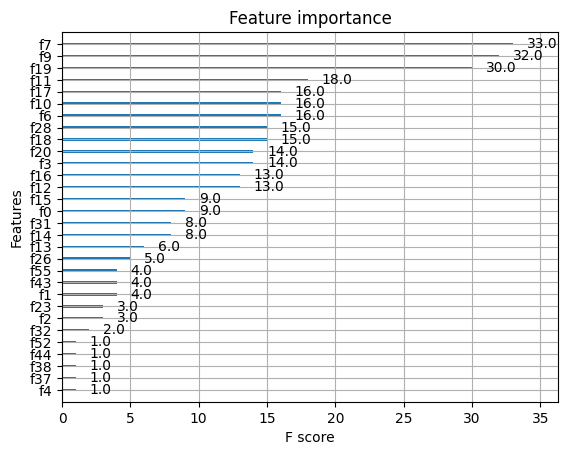

In [61]:
xgboost_model = pipeline.named_steps['classifier'].get_booster()

plot_importance(xgboost_model, importance_type='weight')
plt.show()

In [64]:
feature_map = {col: f'f{i}' for i, col in enumerate(feature_names)}

# Mostrar el mapeo
print(feature_map)

{'MEDICAMENTOS': 'f0', 'MEDICINA ESPECIALIZADA': 'f1', 'MEDICINA GENERAL': 'f2', 'Cant_gr_flia': 'f3', 'Cant_riesgos_flia_mean': 'f4', 'Cant_Fliar_CP': 'f5', 'psa_max_gr_flia': 'f6', 'psa_min_gr_flia': 'f7', 'Cant_Fliar_riesgos': 'f8', 'cantidad_serv_flia': 'f9', 'Pendiente_flia': 'f10', 'Intercepto_flia': 'f11', 'Promedio_costo_flia': 'f12', 'EDAD': 'f13', 'CANTIDAD_SERVICIOS': 'f14', 'TIEMPO_ULTIMA_CITA': 'f15', 'conteo_dx_diferentes': 'f16', 'TIEMPO_AFILIACION': 'f17', 'Pendiente': 'f18', 'Intercepto': 'f19', 'Promedio_costo': 'f20', 'ESTADO_CIVI_CA': 'f21', 'ESTADO_CIVI_SE': 'f22', 'ESTADO_CIVI_SO': 'f23', 'ESTADO_CIVI_UL': 'f24', 'PROGRAMA_PAC': 'f25', 'PROGRAMA_POS': 'f26', 'PROGRAMA_RS': 'f27', 'estrato_1': 'f28', 'estrato_2': 'f29', 'estrato_3': 'f30', 'CANCER_OTRO_SITIO_0': 'f31', 'CANCER_OTRO_SITIO_1': 'f32', 'CANCER_OTRO_SITIO_2': 'f33', 'CANCER_OTRO_SITIO_FAMILIAR_0': 'f34', 'CANCER_OTRO_SITIO_FAMILIAR_1': 'f35', 'CANCER_OTRO_SITIO_FAMILIAR_2': 'f36', 'HIPERTENSION_0': 'f37

In [65]:
feature_map['psa_max_gr_flia']

'f6'

In [66]:
feature_map['psa_min_gr_flia']

'f7'

##### Como ambas variables hacer relación a lo mismo, pero el psa_min_gr_flia tiene mayor peso de significancia en el modelo, entonces se podría eliminar psa_max_gr_flia y hacer una estrategia de imputación por KNN para la otra variable.

##### ESTRATEGIA PARA IMPUTACIÓN DE VARIABLES CATEGÓRICAS (IMC,AGRUPACION_SISTOLICA,AGRUPACION_DIASTOLICA) - Usar Random Forest para predecir la categoría

In [42]:
df_train[df_train['HIPERTENSION']=='1']['AGRUPACION_SISTOLICA'].unique()

array(['Normal', 'hipertenso', None, 'Hipotenso'], dtype=object)

In [43]:
df_train[df_train['HIPERTENSION']=='1']['AGRUPACION_DIASTOLICA'].unique()

array(['Normal', 'hipertenso', 'Hipotenso', None], dtype=object)

In [44]:
df_train[df_train['HIPERTENSION']=='0']['AGRUPACION_DIASTOLICA'].unique()

array(['Normal', None, 'hipertenso', 'Hipotenso'], dtype=object)

In [ ]:
df_train[df_train['HIPERTENSION']=='1']['AGRUPACION_DIASTOLICA'].unique()

In [45]:
df_train[df_train['HIPERTENSION']=='2']['AGRUPACION_DIASTOLICA'].unique()

array(['Normal', None, 'hipertenso', 'Hipotenso'], dtype=object)

In [46]:
mask_distolico_normal = (df_train['AGRUPACION_DIASTOLICA']=='Normal')
mask_distolico_hipertenso = (df_train['AGRUPACION_DIASTOLICA']=='hipertenso')
mask_distolico_hipotenso = (df_train['AGRUPACION_DIASTOLICA']=='Hipotenso')
mask_sistolico_normal = (df_train['AGRUPACION_SISTOLICA']=='Normal')
mask_sistolico_hipertenso = (df_train['AGRUPACION_SISTOLICA']=='hipertenso')
mask_sistolico_hipotenso = (df_train['AGRUPACION_SISTOLICA']=='Hipotenso')

In [47]:
df_train[mask_distolico_normal&mask_sistolico_normal]['HIPERTENSION'].unique()

array(['0', '1', '2'], dtype=object)

#### ESTRATEGIA PARA RIEGOS: Conteo de las variables (CANCER_MAMA_FAMILIAR,	CANCER_OTRO_SITIO,	CANCER_OTRO_SITIO_FAMILIAR,	HIPERTENSION,	HIPERTENSION_FAMILIAR,	DIABETES,	DIABETES_FAMILIAR,	CORONARIOS,	CORONARIOS_FAMILIAR	CEREBRAL,	CEREBRAL_FAMILIAR,	ENFERMEDAD_RENAL,	ENFERMEDAD_RENAL_FAMILIAR,	OTROS_ANTECEDENTES_VASCULARES)

##### ESTRATEGIA CANCER_MAMA_FAMILIAR: Siguiendo el comportamiento de los datos, los None, puede considerarse como un dato desconocido, y no sería correcto hacer ninguna imputación, por tanto se genera la otra categoría (2), como las otras variables categóricas.

# ANÁLISIS DE OUTLIERS

In [108]:
numerical_columns

Index(['MEDICAMENTOS', 'MEDICINA ESPECIALIZADA', 'MEDICINA GENERAL',
       'Cant_gr_flia', 'Cant_riesgos_flia_mean', 'min_Tiempo_CP_Fliar',
       'Cant_Fliar_CP', 'psa_max_gr_flia', 'psa_min_gr_flia',
       'Cant_Fliar_riesgos', 'cantidad_serv_flia', 'Pendiente_flia',
       'Intercepto_flia', 'Promedio_costo_flia', 'EDAD', 'RIESGOS',
       'CANTIDAD_SERVICIOS', 'PERDIDA_DE_PESO', 'TIEMPO_ULTIMA_CITA',
       'conteo_dx_diferentes', 'TIEMPO_AFILIACION', 'Target', 'Pendiente',
       'Intercepto', 'Promedio_costo'],
      dtype='object')

In [109]:
df_train['Cant_Fliar_CP'].info()

<class 'pandas.core.series.Series'>
Index: 23494 entries, 16484 to 9409
Series name: Cant_Fliar_CP
Non-Null Count  Dtype  
--------------  -----  
23494 non-null  float64
dtypes: float64(1)
memory usage: 367.1 KB


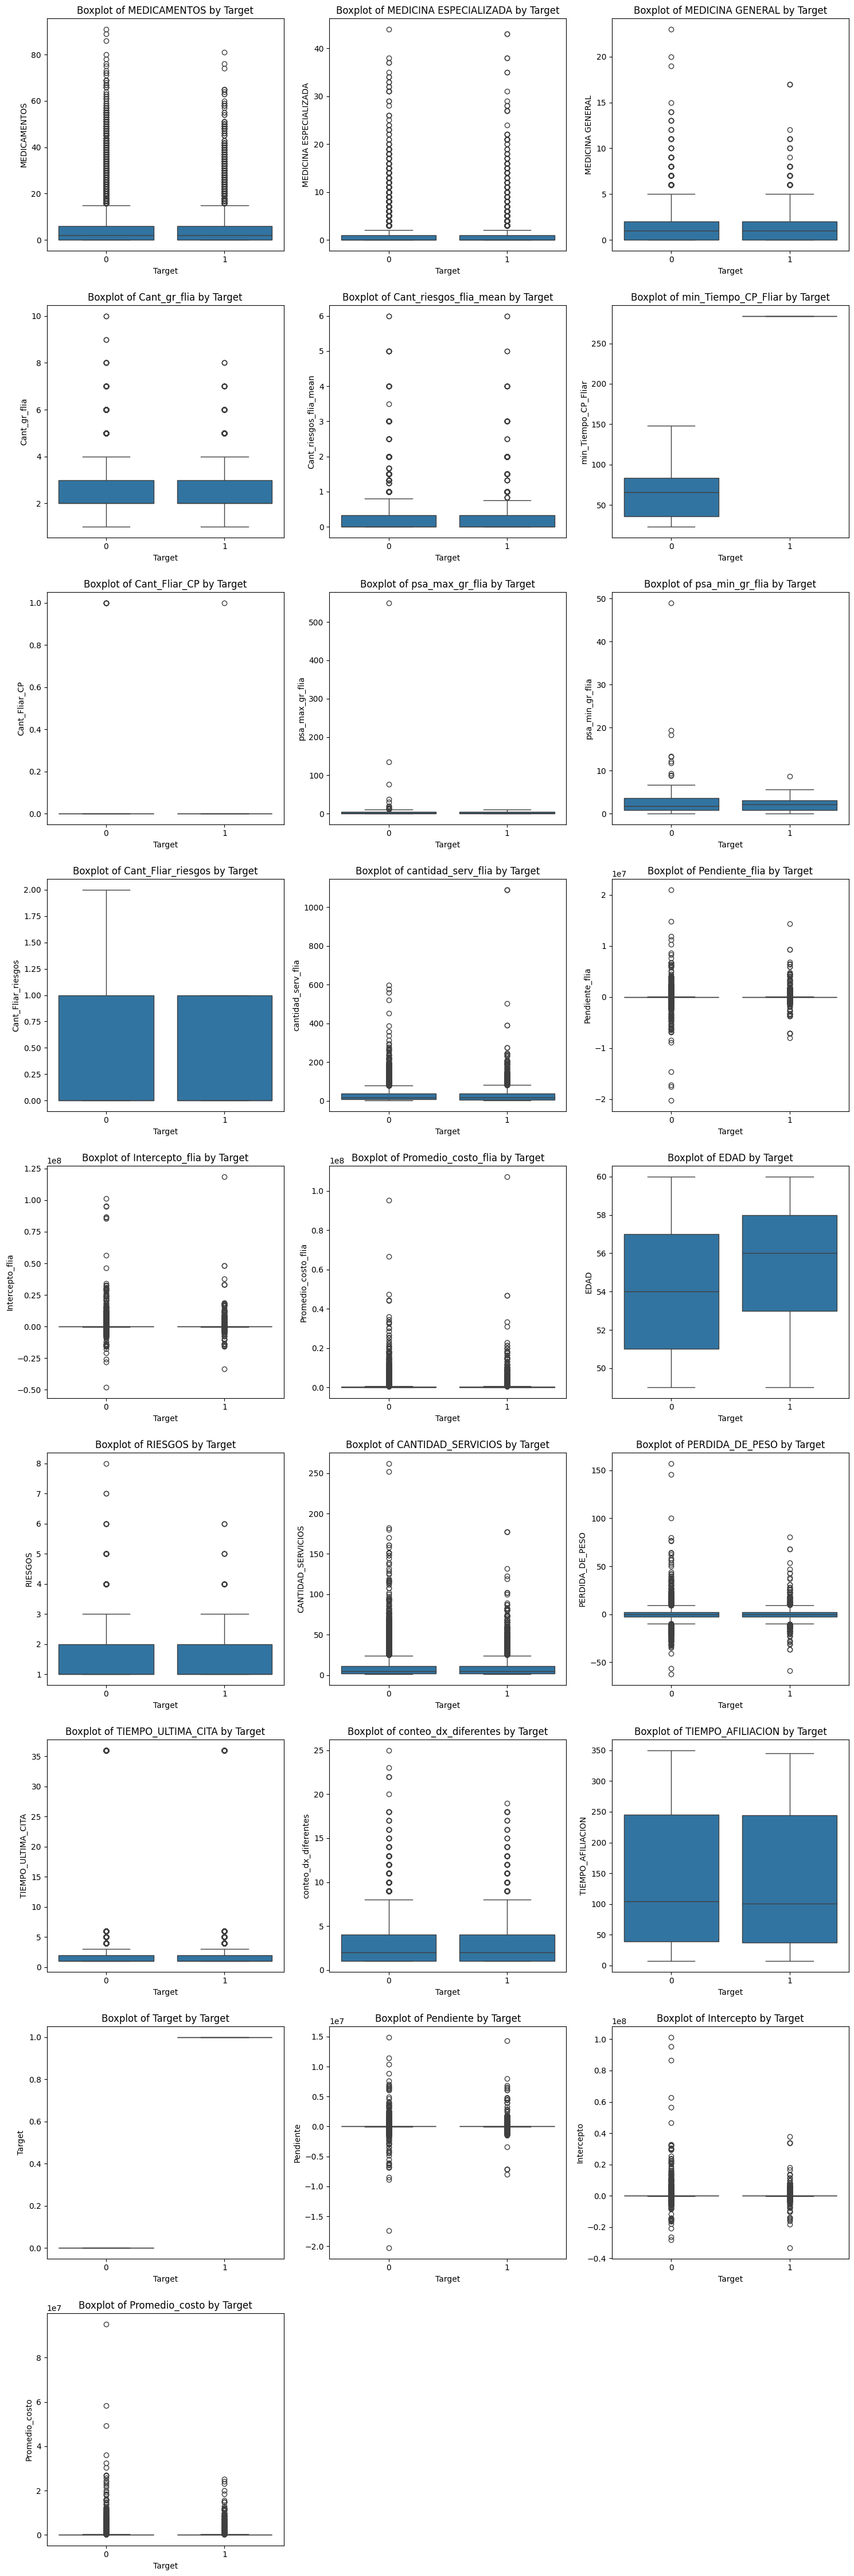

In [71]:
numerical_columns = df_train.select_dtypes(include=['number']).columns

n_cols = 3
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten() 

for i, col in enumerate(numerical_columns):
    sns.boxplot(x='Target', y=col, data=df_train, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} by Target')
    axes[i].set_xlabel('Target')
    axes[i].set_ylabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


##### REVISAR LA VARIABLES REALACIONADAS CON COSTOS PORQUE TIENEN DEMASIADOS OUTLIERS

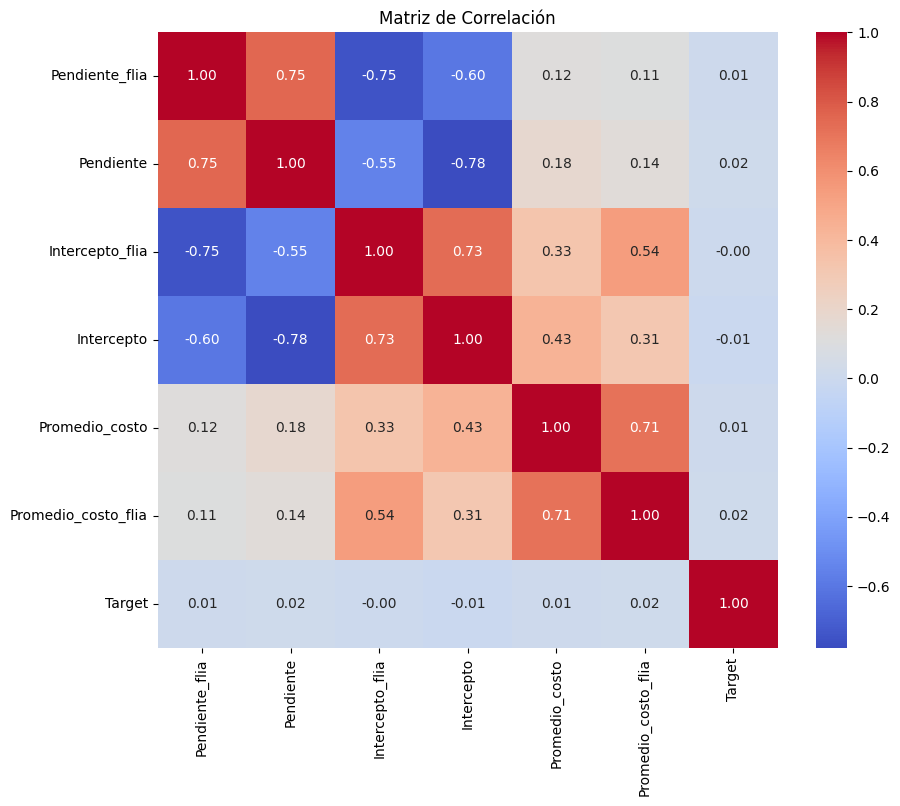

In [127]:
correlation_matrix = df_train[['Pendiente_flia','Pendiente','Intercepto_flia',
                               'Intercepto','Promedio_costo','Promedio_costo_flia','Target']].corr()

# Visualización con Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

##### Dado que todas las variables no tienen correlación con el target y entre ellas están altamente correlacionadas, y pensándo en la lógica del problema, enq ue realmente las variables de costo no deberían afectar el risgo de un paciente a tener o no un PCA anormal, se decide eliminar todas las variables.

##### REVISIÓN PÉRDIDA DE PESO: SE ESTABLECE UN MÁX DE 100 KG DE GANANCIA Y UN MÁXIMO DE 50 KG DE PÉRDIDA PARA REVISAR ATÍPICOS Y SE COMPARAN CON EL VALOR DEL IMC. 

In [72]:
error_arriba = df_train[df_train['PERDIDA_DE_PESO']>100]
error_abajo = df_train[df_train['PERDIDA_DE_PESO']<-50]

In [73]:
error_arriba

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,cantidad_serv_flia,Pendiente_flia,Intercepto_flia,Promedio_costo_flia,ESTADO_CIVI,PROGRAMA,estrato,IMC,AGRUPACION_SISTOLICA,AGRUPACION_DIASTOLICA,parentesco,EDAD,RIESGOS,CANTIDAD_SERVICIOS,PERDIDA_DE_PESO,TIEMPO_ULTIMA_CITA,conteo_dx_diferentes,TIEMPO_AFILIACION,CANCER_MAMA_FAMILIAR,CANCER_OTRO_SITIO,CANCER_OTRO_SITIO_FAMILIAR,HIPERTENSION,HIPERTENSION_FAMILIAR,DIABETES,DIABETES_FAMILIAR,CORONARIOS,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17135,11.0,7.0,4.0,2,0.0,NaN,0.0,NaN,NaN,0.0,36.0,-41398.971429,242377.400000,292443.00,SO,RS,1,Obesidad,Normal,Normal,Sin Descripcion,55.0,NaN,31.0,145.59,1.0,13.0,20.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-15123.257143,277294.066667,224362.666667
6420,4.0,5.0,0.0,2,0.0,NaN,0.0,NaN,NaN,0.0,21.0,107075.742857,-192191.266667,273860.75,SE,POS,3,Obesidad,Normal,hipertenso,NaN,51.0,NaN,13.0,157.14,1.0,8.0,310.0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,77841.600000,-148399.600000,186069.000000


In [74]:
error_abajo

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,cantidad_serv_flia,Pendiente_flia,Intercepto_flia,Promedio_costo_flia,ESTADO_CIVI,PROGRAMA,estrato,IMC,AGRUPACION_SISTOLICA,AGRUPACION_DIASTOLICA,parentesco,EDAD,RIESGOS,CANTIDAD_SERVICIOS,PERDIDA_DE_PESO,TIEMPO_ULTIMA_CITA,conteo_dx_diferentes,TIEMPO_AFILIACION,CANCER_MAMA_FAMILIAR,CANCER_OTRO_SITIO,CANCER_OTRO_SITIO_FAMILIAR,HIPERTENSION,HIPERTENSION_FAMILIAR,DIABETES,DIABETES_FAMILIAR,CORONARIOS,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
574,49.0,2.0,0.0,3,1.666667,NaN,0.0,NaN,NaN,1.0,123.0,-4.765321e+05,3.297992e+06,1.630129e+06,CA,POS,1,Bajo peso,Normal,Normal,Trabajador,59.0,5.0,41.0,-62.50,1.0,7.0,222.0,NaN,2,2,2,2,2,2,2,2,2,2,2,2,2,0,-5.420904e+05,3.607981e+06,1710665.0
4540,5.0,1.0,1.0,6,0.000000,NaN,0.0,NaN,NaN,0.0,35.0,2.713649e+04,-4.806120e+04,9.383300e+04,UL,POS,1,Sobrepeso,Normal,Normal,NaN,50.0,NaN,12.0,-56.57,1.0,5.0,293.0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,9.076286e+02,2.165255e+05,263642.6
28928,21.0,5.0,1.0,1,2.000000,NaN,0.0,NaN,NaN,1.0,32.0,-1.083117e+06,6.463464e+06,2.672555e+06,CA,POS,1,Normal,Normal,Normal,NaN,52.0,2.0,26.0,-58.79,1.0,8.0,81.0,NaN,2,2,2,2,2,2,2,2,2,2,2,2,2,1,-1.223472e+06,7.157382e+06,2875231.0


##### DADO QUE LOS DE MAYOR SUBIDA ESTAN CATEGORIZADOS COMO OBESIDAD Y SOBRE PESO, SE CONSIDERAN ATÍPICOS Y NO ERRORES, Y DE IGUAL MANERA, LOS QUE PERDIERON MUCHO PESO, UNO QUEDA CATALOGADO COMO BAJO PESO, LO QUE TIENE SENTIDO, Y LOS OTROS NORMAL Y SOBREPESO, ES PORQUE UNO LOGRÓ LLEGAR A SU PESO NORMAL, Y LOS DE SOBREPESO AÚN DEBEN BAJAR, PERO UNA PERSONA PUEDE ESTAR EN SOBREPESO, MUY CERCANO A UN PESO NORMAL, ASÍ QUE NO SE CONSIDERAN ERRORES.

#### Polifarmacia: Generalmente, cuando una persona toma cinco o más medicamentos simultáneamente, se considera que está en un estado de polifarmacia. POR ESTA RAZÓN, SE REVISAN TODOS LOS QUE TENGAN MÁS DE 5 MEDICAMENTOS

In [75]:
df_train[df_train['MEDICAMENTOS']>5].describe()

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,cantidad_serv_flia,Pendiente_flia,Intercepto_flia,Promedio_costo_flia,EDAD,RIESGOS,CANTIDAD_SERVICIOS,PERDIDA_DE_PESO,TIEMPO_ULTIMA_CITA,conteo_dx_diferentes,TIEMPO_AFILIACION,Target,Pendiente,Intercepto,Promedio_costo
count,6207.000000,6207.000000,6207.00000,6207.000000,6207.000000,2.000000,6207.000000,50.000000,50.000000,6207.00000,6207.000000,6.207000e+03,6.207000e+03,6.207000e+03,6207.000000,4120.000000,6207.000000,3440.000000,6207.000000,6207.000000,6207.000000,6207.000000,6.207000e+03,6.207000e+03,6.207000e+03
mean,16.108265,2.617206,2.00580,2.415499,0.491388,165.000000,0.000322,7.801460,2.730900,0.55518,46.924601,1.326611e+04,4.983749e+05,6.811651e+05,54.913485,1.661408,19.503303,-0.056837,1.964234,4.865152,139.067827,0.274690,1.353494e+04,4.341465e+05,5.540169e+05
std,11.259309,3.948069,1.82879,1.114565,0.682801,168.291414,0.017949,21.371162,3.407996,0.49731,42.835660,7.733075e+05,3.553023e+06,2.516419e+06,3.462998,0.893811,17.016114,7.774129,3.573095,2.748103,105.347451,0.446394,7.429468e+05,3.343400e+06,2.218485e+06
min,6.000000,0.000000,0.00000,1.000000,0.000000,46.000000,0.000000,0.006000,0.005000,0.00000,6.000000,-2.028200e+07,-3.338319e+07,0.000000e+00,49.000000,1.000000,1.000000,-62.500000,1.000000,1.000000,7.000000,0.000000,-2.030057e+07,-3.337852e+07,1.890000e+03
25%,8.000000,0.000000,1.00000,2.000000,0.000000,105.500000,0.000000,1.222500,0.799750,0.00000,22.000000,-1.409534e+04,0.000000e+00,4.218450e+04,52.000000,1.000000,10.000000,-2.630000,1.000000,3.000000,41.000000,0.000000,-1.857983e+04,5.765867e+03,5.692517e+04
50%,12.000000,1.000000,2.00000,2.000000,0.333333,165.000000,0.000000,2.635000,1.600000,1.00000,37.000000,7.178768e-13,4.372200e+04,1.431014e+05,55.000000,1.000000,15.000000,0.000000,1.000000,4.000000,107.000000,0.000000,8.245429e+02,7.458773e+04,1.319770e+05
75%,21.000000,3.000000,3.00000,3.000000,0.750000,224.500000,0.000000,5.040000,3.265000,1.00000,60.000000,2.132270e+04,2.608377e+05,3.978327e+05,58.000000,2.000000,23.000000,1.892500,2.000000,6.000000,247.000000,1.000000,2.208757e+04,2.531660e+05,3.198738e+05
max,91.000000,44.000000,23.00000,10.000000,6.000000,284.000000,1.000000,135.000000,18.300000,2.00000,1090.000000,1.482665e+07,1.010938e+08,9.512073e+07,60.000000,8.000000,262.000000,145.590000,36.000000,25.000000,348.000000,1.000000,1.490708e+07,1.013168e+08,9.516344e+07


##### ANALIZAR DE FORMA SEPARADA LOS MAYORES AL PERCENTIL 25 - LOS IGUALES O MENORES SE CONSIDERAN ATÍPICOS PERO NO ERRORES

In [76]:
df_train[df_train['MEDICAMENTOS']>8].describe()

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,cantidad_serv_flia,Pendiente_flia,Intercepto_flia,Promedio_costo_flia,EDAD,RIESGOS,CANTIDAD_SERVICIOS,PERDIDA_DE_PESO,TIEMPO_ULTIMA_CITA,conteo_dx_diferentes,TIEMPO_AFILIACION,Target,Pendiente,Intercepto,Promedio_costo
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,2.000000,4424.000000,35.000000,35.000000,4424.000000,4424.000000,4.424000e+03,4.424000e+03,4.424000e+03,4424.000000,3338.000000,4424.000000,2696.000000,4424.000000,4424.000000,4424.000000,4424.000000,4.424000e+03,4.424000e+03,4.424000e+03
mean,19.837025,2.921790,2.130425,2.398960,0.572882,165.000000,0.000452,9.597229,2.751457,0.625678,52.511302,1.239544e+04,5.473805e+05,7.102328e+05,55.125226,1.732475,22.178345,-0.003939,1.892405,5.176085,140.539783,0.273508,9.251261e+03,5.179982e+05,6.148443e+05
std,11.366139,4.141651,1.945896,1.099898,0.721524,168.291414,0.021260,25.410456,4.013923,0.484469,37.100140,8.448218e+05,3.884996e+06,2.672107e+06,3.441860,0.929666,18.121031,7.935757,3.431207,2.899626,105.232390,0.445810,8.360006e+05,3.747253e+06,2.498845e+06
min,9.000000,0.000000,0.000000,1.000000,0.000000,46.000000,0.000000,0.006000,0.005000,0.000000,9.000000,-2.028200e+07,-3.338319e+07,0.000000e+00,49.000000,1.000000,2.000000,-62.500000,1.000000,1.000000,7.000000,0.000000,-2.030057e+07,-3.337852e+07,1.890000e+03
25%,12.000000,0.000000,1.000000,2.000000,0.000000,105.500000,0.000000,0.826000,0.664000,0.000000,28.000000,-1.742950e+04,0.000000e+00,5.218545e+04,52.000000,1.000000,12.000000,-2.560000,1.000000,3.000000,42.750000,0.000000,-2.365638e+04,1.514338e+04,6.525320e+04
50%,16.000000,1.000000,2.000000,2.000000,0.333333,165.000000,0.000000,2.180000,1.380000,1.000000,44.000000,0.000000e+00,6.570193e+04,1.621285e+05,55.000000,1.000000,17.000000,0.000000,1.000000,4.000000,109.000000,0.000000,-1.013571e+02,1.025413e+05,1.554678e+05
75%,24.000000,4.000000,3.000000,3.000000,1.000000,224.500000,0.000000,5.510000,2.480000,1.000000,67.000000,2.362973e+04,3.152819e+05,4.375655e+05,58.000000,2.000000,27.000000,2.040000,2.000000,7.000000,248.000000,1.000000,2.340101e+04,3.130411e+05,3.623492e+05
max,91.000000,44.000000,23.000000,8.000000,6.000000,284.000000,1.000000,135.000000,18.300000,2.000000,597.000000,1.482665e+07,1.010938e+08,9.512073e+07,60.000000,8.000000,262.000000,145.590000,36.000000,25.000000,348.000000,1.000000,1.490708e+07,1.013168e+08,9.516344e+07


##### BASÁNDOSE EN LA TEORÍA MÉDICA, SE CONSIDERAN ERRORES, POR LO TANTO DATOS NULOS, TODOS LOS QUE SUPERAN EL PERCENTIL 25%. LA ESTRATEGIA DE IMPUTACIÓN_ MEDIANA.

In [77]:
print(f"mayores {len(df_train[df_train['MEDICAMENTOS']>8])}")
print(f"menores {len(df_train[df_train['MEDICAMENTOS']<=8])}")

mayores 4424
menores 19070


##### REVISAR LOS ATÍPICOS EN CANTIDAD DE SERVICIOS DEL USUARIO Y GRUPO FAMILIAR

In [78]:
df_train['CANTIDAD_SERVICIOS'].describe()

count    23494.000000
mean         8.861156
std         12.090472
min          1.000000
25%          2.000000
50%          5.000000
75%         11.000000
max        262.000000
Name: CANTIDAD_SERVICIOS, dtype: float64

In [79]:
df_train[df_train['CANTIDAD_SERVICIOS']>df_train['CANTIDAD_SERVICIOS'].quantile(0.75)][['MEDICINA ESPECIALIZADA',
                                                                                        'MEDICINA GENERAL',
                                                                                        'CANTIDAD_SERVICIOS',
                                                                                        'CANCER_OTRO_SITIO',
                                                                                        'HIPERTENSION',
                                                                                        'DIABETES',
                                                                                        'CORONARIOS',
                                                                                        'CEREBRAL',
                                                                                        'ENFERMEDAD_RENAL',
                                                                                        'OTROS_ANTECEDENTES_VASCULARES']]

,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,CANTIDAD_SERVICIOS,CANCER_OTRO_SITIO,HIPERTENSION,DIABETES,CORONARIOS,CEREBRAL,ENFERMEDAD_RENAL,OTROS_ANTECEDENTES_VASCULARES
ID,,,,,,,,,,
16484,3.0,3.0,14.0,0,0,0,0,0,0,0
26630,0.0,2.0,17.0,0,1,0,0,0,0,0
31830,16.0,0.0,49.0,0,0,0,0,0,0,0
14447,2.0,5.0,15.0,2,2,2,2,2,2,2
4829,5.0,1.0,19.0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
3796,5.0,3.0,16.0,0,0,0,0,0,0,0
25438,0.0,1.0,15.0,0,0,1,0,0,0,0
4792,2.0,0.0,25.0,1,1,0,0,0,0,0


In [80]:
df_train['suma_servicios_medicina'] = df_train['MEDICINA GENERAL']+df_train['MEDICINA ESPECIALIZADA']
df_train['dif_cant_serv'] = df_train['CANTIDAD_SERVICIOS']-df_train['suma_servicios_medicina']
df_train['dif_cant_serv'].describe()

count    23494.000000
mean         6.331872
std          9.953780
min          0.000000
25%          1.000000
50%          3.000000
75%          8.000000
max        240.000000
Name: dif_cant_serv, dtype: float64

#### ESTRATEGIA: WINSORIZAR - IMPUTAR EL VALOR DEL QUANTILE 95 A LOS QUE SUPEREN ESTE VALOR

In [104]:
upper_limit = df_train['CANTIDAD_SERVICIOS'].quantile(0.97)

In [ ]:
df_train['CANTIDAD_SERVICIOS'] = np.where(((df_train['dif_cant_serv'] > df_train['dif_cant_serv'].quantile(0.95)) &
                                           (df_train['CANTIDAD_SERVICIOS']>upper_limit))
                                          ,upper_limit, df_train['CANTIDAD_SERVICIOS'])
df_train.drop(columns=['dif_cant_serv', 'suma_servicios_medicina'])

#### PARA LAS VARIABLES ...XXXXX QUE MUESTRAN EN SU BOXPLOT ATÍPICOS, BASADOS EN EL CONOCIMIENTO DEL NEGOCIO NO SE CONSIDERAN ATÍPICOS